In [1]:
import os

In [2]:
!gdown 1RxLFWqZRLbt3XYFjGve8zr-f0TYYE0iH

Downloading...
From: https://drive.google.com/uc?id=1RxLFWqZRLbt3XYFjGve8zr-f0TYYE0iH
To: /content/car-or-truck.zip
100% 81.5M/81.5M [00:02<00:00, 29.5MB/s]


In [3]:
!unzip car-or-truck.zip -d car-or-truck

Streaming output truncated to the last 5000 lines.
  inflating: car-or-truck/valid/Car/05205.jpeg  
  inflating: car-or-truck/valid/Car/05206.jpeg  
  inflating: car-or-truck/valid/Car/05208.jpeg  
  inflating: car-or-truck/valid/Car/05213.jpeg  
  inflating: car-or-truck/valid/Car/05214.jpeg  
  inflating: car-or-truck/valid/Car/05217.jpeg  
  inflating: car-or-truck/valid/Car/05218.jpeg  
  inflating: car-or-truck/valid/Car/05219.jpeg  
  inflating: car-or-truck/valid/Car/05221.jpeg  
  inflating: car-or-truck/valid/Car/05222.jpeg  
  inflating: car-or-truck/valid/Car/05225.jpeg  
  inflating: car-or-truck/valid/Car/05226.jpeg  
  inflating: car-or-truck/valid/Car/05227.jpeg  
  inflating: car-or-truck/valid/Car/05228.jpeg  
  inflating: car-or-truck/valid/Car/05234.jpeg  
  inflating: car-or-truck/valid/Car/05236.jpeg  
  inflating: car-or-truck/valid/Car/05238.jpeg  
  inflating: car-or-truck/valid/Car/05239.jpeg  
  inflating: car-or-truck/valid/Car/05241.jpeg  
  inflating: car-o

In [4]:
train_path = './car-or-truck/train/'
test_path = './car-or-truck/valid/'

In [5]:
print(len(os.listdir(train_path + 'Car/')))

2961


In [6]:
print(len(os.listdir(train_path + 'Truck/')))

2156


In [7]:
import cv2
from PIL import Image
import numpy as np

In [8]:
cates = ['Car', 'Truck']

def load_images_and_labels(data_path, cate):
  x = []
  y = []

  for index, cate in enumerate(cates):
    for img_name in os.listdir(data_path + cate + '/'):

      img = cv2.imread(data_path + cate + '/' + img_name)
      if img is not None:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_array = Image.fromarray(img, 'RGB')
        img_rs = img_array.resize((224, 224))
        img_rs = np.array(img_rs)
        x.append(img_rs)
        y.append(index)
  return x, y

In [9]:
X_train, y_train = load_images_and_labels(train_path, cates)

In [10]:
X_test, y_test = load_images_and_labels(test_path, cates)

In [11]:
print(len(X_test))

5051


In [12]:
import matplotlib.pyplot as plt
import random

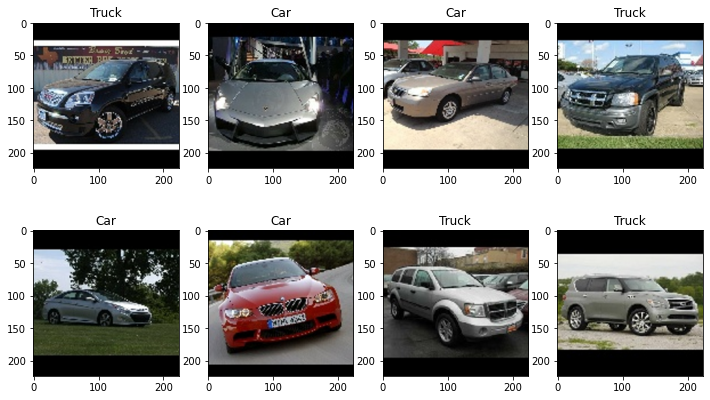

In [13]:
plt.figure(figsize=(12, 7))

for i in range(8):
  ind = random.randint(0, len(X_train))
  plt.subplot(240+1+i)
  plt.imshow(X_train[ind])
  plt.title(cates[y_train[ind]])

In [14]:
from keras.utils import to_categorical

In [15]:
def preprocess_data(X, y):

  X = np.array(X)

  X = X.astype(np.float32)

  X = X/255.0

  y = to_categorical(np.array(y))

  return X, y

In [16]:
(X_train, y_train) = preprocess_data(X_train, y_train)

In [17]:
(X_test, y_test) = preprocess_data(X_test, y_test)

In [18]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

from keras.metrics import binary_crossentropy

from keras.optimizers import SGD

In [19]:
def AlexNet():

  model = Sequential(name='AlexNet')

  model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=(224, 224, 3)))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

  model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
  model.add(Conv2D(filters=384, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
  model.add(MaxPooling2D(pool_size=(3, 3), strides=2))


  model.add(Flatten())
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(4096, activation='relu'))
  model.add(Dropout(0.5))

  model.add(Dense(2, activation='softmax'))


  opt = SGD(lr=0.1)

  model.compile(loss= binary_crossentropy, optimizer=opt, metrics=['accuracy'])

  return model


In [20]:
alexnet_model = AlexNet()
alexnet_model.summary()

Model: "AlexNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       614656    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 256)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 384)       885120    
                                                                 
 conv2d_3 (Conv2D)           (None, 12, 12, 384)       3686

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

In [22]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):

  datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

  it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
  it_test = datagen.flow(X_test, y_test, batch_size=batch_size)


  path_cp = os.getcwd() + '/' + 'weights.hdf5'

  checkpoint = ModelCheckpoint(path_cp, monitor='loss', save_best_only=True, mode='auto')

  steps = X_train.shape[0]//batch_size

  history = model.fit(it_train, epochs= epochs, steps_per_epoch=steps, validation_data=it_test, verbose=1, callbacks=checkpoint)

  _, acc = model.evaluate(it_test, verbose=1)
  print('%.3f' % (acc*100.0))

  return history, acc

In [23]:
tain_history, acc = train_model(alexnet_model, X_train, y_train, X_test, y_test, 1, 128)

40/40 [==============================] - 55s 1s/step - loss: 0.6785 - accuracy: 0.5785
57.850


In [24]:
def plot_accuracy(history):
  plt.figure(figsize=(10, 6))
  plt.plot(history.history['accuracy'], color='blue', label='train')
  plt.plot(history.history['val_accuracy'], color='red', label='val')

  plt.legend()
  plt.show()


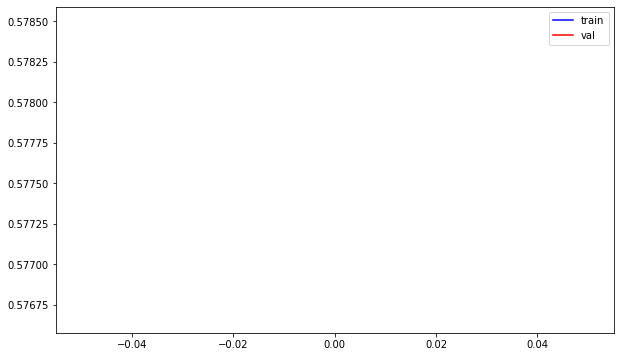

In [26]:
plot_accuracy(tain_history)

## Save the trained model

In [ ]:
alexnet_model.save('Alexnet_model.h5')